# Importing the Dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('/content/Phone Reviews1.csv', encoding='latin-1')
data.head()

,Review,label,Reviewer,Review date,Star Rating,Sentences,batch
0,Review,Galaxy Core,Reviewer,Date,5,09 JULY 13\n \n CERTIFIED BUYER\n ...,1
1,Review,Galaxy Core,Reviewer,Date,5,A GREAT MODEL BY SAMSUNG FOR YOUNGSTERS. THIS ...,2
2,Review,Galaxy Core,Reviewer,Date,5,"AM USING THIS FONE SINCE 6 MONTHS,IT RUNS SO F...",3
3,Review,Galaxy Core,Reviewer,Date,5,"AS I THOUGHT ABOUT IT, I GOT ALL THAT IN IT. A...",4
4,Review,Galaxy Core,Reviewer,Date,5,BATTERY BACK UP IS GOOD IT COMES AROUND ONE AN...,5


In [ ]:
data.isnull().sum()

Review         0
label          0
Reviewer       0
Review date    0
Star Rating    0
Sentences      0
batch          0
dtype: int64

In [ ]:
data.shape

(4710, 7)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data.columns

Index(['Review', 'label', 'Reviewer', 'Review date', 'Star Rating',
       'Sentences', 'batch'],
      dtype='object')

# Data Preprocessing

In [ ]:
mobile = data.copy()

In [ ]:
# Clean the text data in the 'Sentences' column
mobile['Sentences'] = mobile['Sentences'].str.lower().str.replace('[^\w\s]', '')

In [ ]:
# Normalize the numerical data (Star Rating)
scaler = MinMaxScaler()
mobile['Star Rating'] = scaler.fit_transform(mobile[['Star Rating']])

In [ ]:
mobile.head()

,Review,label,Reviewer,Review date,Star Rating,Sentences,batch,Brand
0,review,Galaxy Core,Reviewer,Date,1.0,09 july 13\n \n certified buyer\n ...,1,Samsung
1,review,Galaxy Core,Reviewer,Date,1.0,a great model by samsung for youngsters. this ...,2,Samsung
2,review,Galaxy Core,Reviewer,Date,1.0,"am using this fone since 6 months,it runs so f...",3,Samsung
3,review,Galaxy Core,Reviewer,Date,1.0,"as i thought about it, i got all that in it. a...",4,Samsung
4,review,Galaxy Core,Reviewer,Date,1.0,battery back up is good it comes around one an...,5,Samsung


# Calculating TF-IDF Matrix

In [ ]:
# Step 2: Text representation using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(mobile['Sentences'])

In [ ]:
tfidf_matrix.shape

(4710, 15709)

In [ ]:
data['label'].value_counts()

label
Moto G                        339
Galaxy S Duos                 321
Galaxy Grand                  296
Micromax Canvas HD A116       277
Galaxy Core                   259
Micromax Canvas 4 A210        253
Xperia U                      251
Nokia Lumia 520               240
Micromax Canvas Turbo A250    239
Nokia Lumia 620               227
Xperia C                      222
Nokia Lumia 720               217
Galaxy S3                     210
Galaxy S Advance              197
HTC One V T320                189
Galaxy Note                   164
Nokia Lumia 920               161
Xperia J                      157
Xperia Z                      132
IPhone 5S                     128
HTC One X E720                127
Xperia P                      104
Name: count, dtype: int64

### Creating New Column: "Brand"

In [ ]:
# Define the function to extract the brand
def extract_brand(label):
    if label.startswith('Galaxy'):
        return 'Samsung'
    else:
        return label.split()[0]

In [ ]:
# Apply the function to create the 'Brand' column
mobile['Brand'] = mobile['label'].apply(extract_brand)

In [ ]:
mobile.head()

,Review,label,Reviewer,Review date,Star Rating,Sentences,batch,Brand
0,review,Galaxy Core,Reviewer,Date,1.0,09 july 13\n \n certified buyer\n ...,1,Samsung
1,review,Galaxy Core,Reviewer,Date,1.0,a great model by samsung for youngsters. this ...,2,Samsung
2,review,Galaxy Core,Reviewer,Date,1.0,"am using this fone since 6 months,it runs so f...",3,Samsung
3,review,Galaxy Core,Reviewer,Date,1.0,"as i thought about it, i got all that in it. a...",4,Samsung
4,review,Galaxy Core,Reviewer,Date,1.0,battery back up is good it comes around one an...,5,Samsung


In [ ]:
mobile['Brand'].value_counts()

Brand
Samsung     1447
Xperia       866
Nokia        845
Micromax     769
Moto         339
HTC          316
IPhone       128
Name: count, dtype: int64

# Calculating Similarity Scores for the Brands

In [ ]:
# Aggregate vectors by brand
brand_text_vectors = mobile.groupby('Brand').apply(lambda x: np.mean(tfidf_matrix[x.index].toarray(), axis=0))
brand_ratings = mobile.groupby('Brand')['Star Rating'].mean()

In [ ]:
# Combine text vectors and normalized ratings
combined_features = np.hstack([np.vstack(brand_text_vectors.values), brand_ratings.values.reshape(-1, 1)])

In [ ]:
# Step 4: Calculate similarity scores
brand_similarity = cosine_similarity(combined_features)

In [ ]:
# Create a similarity DataFrame
brands = brand_text_vectors.index.tolist()
similarity_df = pd.DataFrame(brand_similarity, index=brands, columns=brands)

In [ ]:
# Calculate average similarity scores for each brand
avg_similarity_scores = similarity_df.mean(axis=1)

In [ ]:
# Sort brands by average similarity scores in descending order
sorted_brands = avg_similarity_scores.sort_values(ascending=False)

### Visualizing the Heatmap

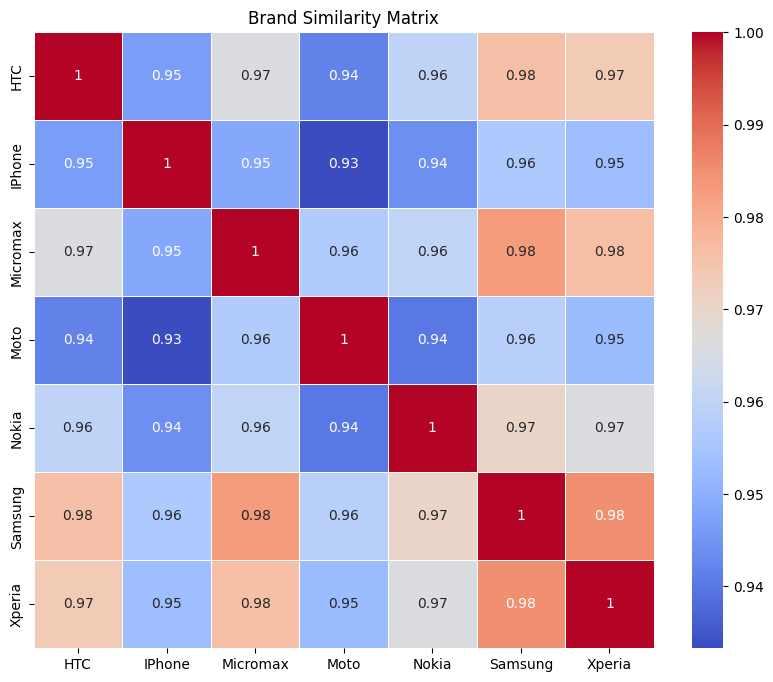

In [ ]:
# Step 5: Visualize the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Brand Similarity Matrix')
plt.show()

# Determinig the Similar Brands

In [ ]:
# Output the ordered list of brands
print("Ordered list of brands based on similarity:")
for brand in sorted_brands.index:
    print(f'{brand}: Average Similarity Score = {sorted_brands[brand]}')

Ordered list of brands based on similarity:
Samsung: Average Similarity Score = 0.9755130182863151
Xperia: Average Similarity Score = 0.9723455589359491
Micromax: Average Similarity Score = 0.9700903916897735
HTC: Average Similarity Score = 0.9661892695538076
Nokia: Average Similarity Score = 0.9628389902142148
Moto: Average Similarity Score = 0.9547114152137594
IPhone: Average Similarity Score = 0.9544859062878631


In [ ]:
# Flatten the similarity matrix to get pairs of brands with their similarity scores
similarity_pairs = []

for i in range(len(brands)):
    for j in range(i+1, len(brands)):
        similarity_pairs.append((brands[i], brands[j], brand_similarity[i, j]))

In [ ]:
# Sort the list of brand pairs based on similarity scores in descending order
sorted_similarity_pairs = sorted(similarity_pairs, key=lambda x: x[2], reverse=True)

In [ ]:
# Output the sorted list of brand pairs with their similarity scores
print("Sorted list of brand pairs based on similarity scores:")
for pair in sorted_similarity_pairs:
    print(f'{pair[0]} and {pair[1]}: Similarity Score = {pair[2]}')

Sorted list of brand pairs based on similarity scores:
Samsung and Xperia: Similarity Score = 0.9849956477296093
Micromax and Samsung: Similarity Score = 0.982963155921033
Micromax and Xperia: Similarity Score = 0.9762450154267808
HTC and Samsung: Similarity Score = 0.9759287200480022
HTC and Xperia: Similarity Score = 0.9733708105061214
Nokia and Samsung: Similarity Score = 0.9704658183158964
HTC and Micromax: Similarity Score = 0.9660119940197768
Nokia and Xperia: Similarity Score = 0.9658986187910177
Micromax and Nokia: Similarity Score = 0.9599664389165632
HTC and Nokia: Similarity Score = 0.9596925517204808
Moto and Samsung: Similarity Score = 0.9581494994334693
Micromax and Moto: Similarity Score = 0.956803468138687
IPhone and Samsung: Similarity Score = 0.9560882865561957
IPhone and Xperia: Similarity Score = 0.9531250961294765
Moto and Xperia: Similarity Score = 0.9527837239686383
IPhone and Micromax: Similarity Score = 0.9486426694055721
HTC and IPhone: Similarity Score = 0.94

As per our observations, **Samsung** and **Xperia** are the most similar brands.